<a href="https://colab.research.google.com/github/artemkurylev/Music_Transcription/blob/master/AMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install comet_ml

In [0]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import librosa
import csv
import time
import h5py
import pickle
import os
from sklearn import preprocessing
from scipy.io import wavfile
import pandas as pd
from sklearn import metrics
from joblib import Parallel, delayed
from librosa import display
from librosa.display import specshow

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch. utils.data import DataLoader
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
class DataProcessor:

    class DataReader:

        def __init__(self):
            self.audios = []
            self.annotations = []

        def read_audios(self, audio_file_paths):
            results = Parallel(n_jobs=-1, verbose=5, backend="threading")(
                map(delayed(self.read_audio), audio_file_paths))
            return results

        def read_audio(self, path):
            audio = librosa.load(path, sr=16000)
            if audio:
                self.audios.append(audio)

    def __init__(self, path):
        self.path = path
        self.chroma_cqts = []
        self.cqts = []
        self.annotations = None
        self.audios = None
        self.files = recursive_file_search(self.path)
        try:
            self.txt_files = [file for file in self.files if file.endswith('.txt')]
            self.audio_files = [file for file in self.files if file.endswith('.wav')]

        except FileNotFoundError:
            print('Please enter correct Path - some of your files not found')
            return

    def load_annotations(self):
        self.annotations = [pd.read_csv(filename, sep='\t') for filename in self.txt_files]
        for i in range(len(self.annotations)):
            min_onset = self.annotations[i]['OnsetTime'].min()
            padding_row = pd.DataFrame({"OnsetTime": [0.0],"OffsetTime":[min_onset],"MidiPitch":[0]})
            self.annotations[i] = pd.concat([self.annotations[i],padding_row],ignore_index=True)
            self.annotations[i] = self.annotations[i].sort_values(by='OnsetTime',)

    def load_audios(self, sr=None):
        if sr is not None:
            dr = DataProcessor.DataReader()
            dr.read_audios(self.audio_files)
            self.audios = dr.audios
        else:
            self.audios = [librosa.load(filename) for filename in self.audio_files]

    def generate_chroma_cqt_images(self, output_path):
        for i in range(len(self.audios)):
            chroma_cqt = librosa.feature.chroma_cqt(self.audios[i][0], self.audios[i][1])
            self.chroma_cqts.append(chroma_cqt)
            plt.figure(figsize=(15, 20))
            plt.subplot(2, 1, 2)
            display.specshow(chroma_cqt, y_axis='chroma', x_axis='time')
            plt.title('chroma_cqt')
            plt.colorbar()
            plt.savefig(os.path.join(output_path, self.txt_files[i][:3] + 'png'), bbox_inches='tight')

    def generate_cqts(self, hop_length=512, fmin=None, n_bins=84, bins_per_octave=12,
                      tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', scale=True, pad_mode='reflect'):
        self.cqts = []
        for i in range(len(self.audios)):
            chroma_cqt = np.abs(librosa.cqt(self.audios[i][0], self.audios[i][1],  hop_length, fmin, n_bins,
                                bins_per_octave, tuning, filter_scale, norm, sparsity, window, scale, pad_mode))
            self.cqts.append(chroma_cqt)
    
    #def generate_cqt()

    @staticmethod
    def one_hot(series):
        res = np.zeros(107)
        list_values = series.values.tolist()
        for val in list_values:
            if type(val) == int:
                try:
                    res[val-21] = 1
                except Exception:
                    print('-0000-0-0-0-')
                    print(val)
                    print(list_values)
        return res.tolist()

    @staticmethod
    def simple_one_hot(series):
        list_values = np.array(series.values.tolist())
        return list_values.argmax()

    def get_cqt_data(self, freq):
        X = []
        y = []
        shapes = []
        for chroma in self.cqts:
            shapes.append(chroma.shape[1])
            X.extend(chroma.reshape(chroma.shape[1], chroma.shape[0]))

        for i in range(len(shapes)):
            new_freq = shapes[i]
            try:
                self.annotations[i]['frame'] = pd.cut(self.annotations[i].OnsetTime, new_freq)
            except IndexError:
                print('Index out of range: ', i, ' > ', len(self.annotations))
            grouped_annotation = self.annotations[i][['MidiPitch', 'frame']].groupby(by='frame', as_index=False)\
                .agg(DataProcessor.one_hot)
            
            grouped_annotation['FixedMidiPitch'] = grouped_annotation['MidiPitch'].fillna(method='pad')
            
            y.extend(grouped_annotation['FixedMidiPitch'])
        Xy = pd.DataFrame(X)
        y = pd.Series(y,name='FixedMidiPitch')
        Xy= pd.concat((Xy,y),axis=1)
        Xy = Xy
        
        return Xy.loc[:, Xy.columns != 'FixedMidiPitch'].values.tolist(), Xy['FixedMidiPitch']

In [0]:
def recursive_file_search(folder):
    files = [os.path.join(folder, file) for file in os.listdir(folder) if os.path.isfile(os.path.join(folder, file))]
    folders = [os.path.join(folder, file) for file in os.listdir(folder) if os.path.isdir(os.path.join(folder, file))]
    if folders:
        for next_folder in folders:
            files.extend(recursive_file_search(next_folder))

    return files

In [3]:
!wget https://amubox.univ-amu.fr/s/iNG0xc5Td1Nv4rR/download
!unzip download
!rm download

!unzip 'MAPS/AkPnBcht.zip' 
!rm 'MAPS/AkPnBcht.zip'
!unzip 'MAPS/AkPnBsdf.zip'
!rm 'MAPS/AkPnBsdf.zip'
!unzip 'MAPS/AkPnCGdD.zip'
!rm 'MAPS/AkPnCGdD.zip'
!unzip 'MAPS/AkPnStgb.zip'
!rm 'MAPS/AkPnStgb.zip'
!unzip 'MAPS/ENSTDkAm1.zip'
!rm 'MAPS/ENSTDkAm1.zip'
!unzip 'MAPS/ENSTDkAm2.zip'
!rm 'MAPS/ENSTDkAm2.zip'
!unzip 'MAPS/ENSTDkCl.zip'
!rm 'MAPS/ENSTDkCl.zip'
!unzip 'MAPS/SptkBGAm.zip'
!rm 'MAPS/SptkBGAm.zip'
!unzip 'MAPS/SptkBGCl.zip'
!rm 'MAPS/SptkBGCl.zip'
!unzip 'MAPS/StbgTGd2.zip'
!rm 'MAPS/StbgTGd2.zip'

--2020-04-16 09:18:40--  https://amubox.univ-amu.fr/s/iNG0xc5Td1Nv4rR/download
Resolving amubox.univ-amu.fr (amubox.univ-amu.fr)... 139.124.245.127
Connecting to amubox.univ-amu.fr (amubox.univ-amu.fr)|139.124.245.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘download’

download                [<=>                 ]       0  --.-KB/s               ^C
Archive:  download
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of download or
        download.zip, and cannot find download.ZIP, period.


KeyboardInterrupt: ignored

In [2]:
!mv 'AkPnBcht/' 'MAPS/'
!mv 'AkPnBsdf/' 'MAPS/'
!mv 'AkPnCGdD/' 'MAPS/'
!mv 'AkPnStgb/' 'MAPS/'
!mv 'ENSTDkAm/' 'MAPS/'
!mv 'ENSTDkCl/' 'MAPS/'
!mv 'SptkBGAm/' 'MAPS/'
!mv 'SptkBGCl/' 'MAPS/'
!mv 'StbgTGd2//' 'MAPS/'

mv: cannot stat 'AkPnBcht/': No such file or directory


In [0]:
class ANN(nn.Module):
    def __init__(self, input_size, activation, output_size, dropout=None, bn=None):
        super(ANN, self).__init__()

        def ann_block(in_neurons, out_neurons, activation, dropout=None, bn=None):
            block = [nn.Linear(in_neurons, out_neurons), activation]
            if dropout is not None:
                block.append(dropout)
            if bn is not None:
                block.append(bn)
            return block

        self.model = nn.Sequential(
            *ann_block(input_size, 512, dropout, bn),
            *ann_block(512, 1024, activation, dropout),
            *ann_block(1024, 2048, activation, dropout),
            *ann_block(2048, 2048, activation, dropout),
            *ann_block(2048, 1024, activation, dropout),
            *ann_block(1024, 512, activation, dropout),
            *ann_block(512, 256, activation, dropout),
            *ann_block(256, output_size, activation, dropout)
        )

    def forward(self, x):
        shape = x.shape[0]
        return self.model(x.view(shape, -1))

##### Read and preprocess data

In [11]:
path = 'MAPS/AkPnCGdD/'
dp = DataProcessor(path)
dp.load_audios(sr=16000)
dp.load_annotations()
dp.generate_cqts(bins_per_octave=36,hop_length=512,n_bins=252)
X,y = dp.get_cqt_data(None)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 3735 out of 3735

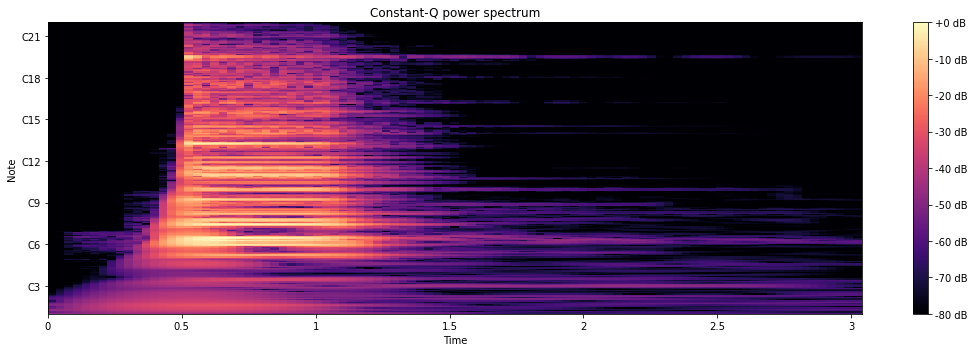

In [12]:
plt.figure(figsize=(15,5))
librosa.display.specshow(librosa.amplitude_to_db(dp.cqts[0], ref=np.max),
                         sr=16000, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.tight_layout()
plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train = torch.from_numpy(np.array(X_train))
X_test = torch.from_numpy(np.array(X_test))

temp_train = []
temp_test = []
for i in y_train:
    temp_train.append(i)
for i in y_test:
    temp_test.append(i)
y_train = torch.tensor(temp_train)
y_test = torch.tensor(temp_test)

In [0]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
batch_size = 200
# Data loaders
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size, shuffle=False)

In [0]:
# Testing model
def test( class_predictor, device, test_loader):
    class_predictor.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.reshape(data.shape[0],data.shape[1],1)
            data = data.to(device)
            labels = target
            target =  labels.clone().detach().squeeze().to(device).long()
            output = model(data.float())

            correct += torch.round(torch.sigmoid(output)).eq(target).sum().item()
    return 100. * correct / (len(test_loader.dataset) * 128)

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
def calculate_avg_accuracy(results, target):
    correct = np.zeros(len(results[0]))
    correct = np.add(correct,torch.eq(results,target).sum(dim=0).detach().cpu().numpy())
    correct /= len(results)
    return correct

In [19]:
model = ANN(252,nn.LeakyReLU(),107,nn.Dropout(), nn.BatchNorm1d(512)).to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
epoch_num = 20
log_interval = 200
pos_weigth = torch.Tensor([50]*107).to(device)
loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weigth)

losses = []
accuracies = []
for epoch in range(epoch_num):
    model.train()
    accuracy = 0
    correct = np.zeros(107)
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.reshape(data.shape[0],data.shape[1],1)
        data = data.to(device)
        labels = target
        target =  labels.clone().detach().squeeze().to(device).long()
        
        optimizer.zero_grad()
        output = model(data.float())
        
        loss = loss_function(output.float(), target.float())
        loss.backward()
        optimizer.step()

        ### Train Accuracy 
        cur_accuracy = calculate_avg_accuracy(torch.round(torch.sigmoid(output)), target)
        correct = np.add(correct,cur_accuracy)

        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())
    correct /= len(train_loader)
    #print(correct)
    accuracy = np.mean(correct)
    train_accuracy = 100. * accuracy
    test_accuracy = test(model,device,test_loader)
    
    print('Accuracy is {} on train_dataset'.format(train_accuracy), "\n")


Train Epoch: 0 [0/504810 (0%)]	Loss: 1.122823
Train Epoch: 0 [40000/504810 (8%)]	Loss: 0.880868
Train Epoch: 0 [80000/504810 (16%)]	Loss: 0.916813
Train Epoch: 0 [120000/504810 (24%)]	Loss: 0.824757
Train Epoch: 0 [160000/504810 (32%)]	Loss: 0.870318
Train Epoch: 0 [200000/504810 (40%)]	Loss: 0.894057
Train Epoch: 0 [240000/504810 (48%)]	Loss: 0.837333
Train Epoch: 0 [280000/504810 (55%)]	Loss: 0.890067
Train Epoch: 0 [320000/504810 (63%)]	Loss: 0.802304
Train Epoch: 0 [360000/504810 (71%)]	Loss: 0.801250
Train Epoch: 0 [400000/504810 (79%)]	Loss: 0.725784
Train Epoch: 0 [440000/504810 (87%)]	Loss: 0.857895
Train Epoch: 0 [480000/504810 (95%)]	Loss: 0.866880
Accuracy is 98.69777921717238 on train_dataset 

Train Epoch: 1 [0/504810 (0%)]	Loss: 0.875407
Train Epoch: 1 [40000/504810 (8%)]	Loss: 1.266725
Train Epoch: 1 [80000/504810 (16%)]	Loss: 0.835660
Train Epoch: 1 [120000/504810 (24%)]	Loss: 0.899526
Train Epoch: 1 [160000/504810 (32%)]	Loss: 0.836538
Train Epoch: 1 [200000/504810 (40

In [0]:
def eval(class_predictor,device,test_loader,threshold):
    class_predictor.eval()
    test_loss = 0
    correct = 0
    all_predicted = []
    predicted_probs = []
    one = torch.ones(1).to(device)
    zero = torch.zeros(1).to(device)
    with torch.no_grad():
        for data, target in test_loader:
            data = data.reshape(data.shape[0],data.shape[1],1)
            data = data.to(device)
            labels = target
            target = labels.clone().detach().squeeze().to(device).long()
            output = model(data.float())
            predicted = torch.where(torch.sigmoid(output)>threshold,one,zero).cpu().data.numpy()
            predicted_probs.extend(torch.sigmoid(output).detach().cpu().numpy().tolist())
            all_predicted.extend(predicted)
    return all_predicted,predicted_probs

In [0]:
predictions,probs = eval(model,device,test_loader, 0.4859)
probs_class = [x[50] for x in probs]
true_class = [x[50] for x in y_test]
fpr, tpr, thresholds = roc_curve(true_class, probs_class,)

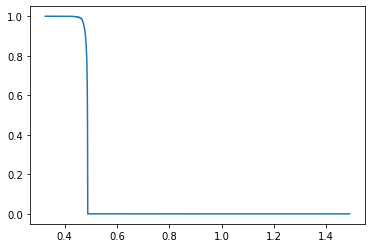

In [166]:
plt.plot(thresholds, tpr)

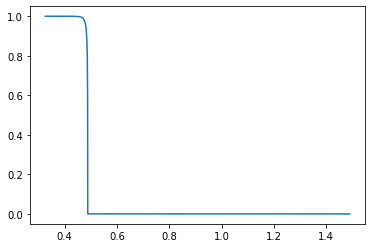

In [167]:
plt.plot(thresholds, fpr)

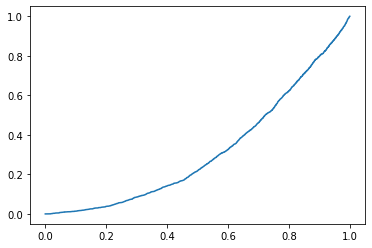

In [168]:
plt.plot(fpr,tpr)

In [169]:
auc_score = auc(fpr,tpr)
auc_score

0.31825575450395804

In [0]:
pred_class = [x[50] for x in predictions]
true_class = [x[50] for x in y_test]

In [0]:
true_positive,false_positive,false_negative, true_negative = 0,0,0,0
for i in range(len(pred_class)):
    if pred_class[i] == true_class[i] and pred_class[i] == 0:
        true_negative += 1
    if pred_class[i] == true_class[i] and pred_class[i] == 1:
        true_positive += 1
    if pred_class[i] != true_class[i] and pred_class[i] == 0:
        false_negative += 1
    if pred_class[i] != true_class[i] and pred_class[i] == 1:
        false_positive += 1

In [172]:
print('true_negative: ', true_negative)
print('true_positive: ', true_positive)
print('false_positive: ', false_positive)
print('false_negative: ', false_negative)

true_negative:  19252
true_positive:  1687
false_positive:  104535
false_negative:  729


In [173]:
precision = true_positive/(false_positive+true_positive)
recall = true_positive/(true_positive+false_negative)
f1_score = 2*(precision*recall)/(precision+recall)
print('Precision: ', precision)
print('Recall: ', recall)
print('F-score: ', f1_score)

Precision:  0.015881832388770688
Recall:  0.6982615894039735
F-score:  0.031057272777481174
